In [73]:
from __future__ import annotations

import json
import hashlib
import math
import os.path
from pathlib import Path
import pickle
import random
from time import perf_counter
from typing import Optional

import cv2
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy.spatial.distance import euclidean
from scipy import ndimage
from skimage import filters, restoration, morphology
import tifffile

from histalign.backend.ccf.downloads import (
    download_annotation_volume,
    download_structure_mask,
)
from histalign.backend.ccf.paths import get_annotation_path, get_structure_mask_path
from histalign.backend.io import load_volume
from histalign.backend.models import Resolution

In [74]:
%cd /home/odelree/notebooks

/home/odelree/notebooks


In [75]:
def imshow(
    image: np.ndarray,
    title: str | None = None,
    figsize: tuple[int, int] | None = None,
    cmap: str | None = "gray",
) -> None:
    global _distinct_colours

    _ = plt.figure(figsize=figsize)

    if title is not None:
        plt.suptitle(title)
    plt.axis(False)

    if cmap == "distinct":
        cmap = generate_distinct_cmap(image)

    plt.imshow(image, cmap=cmap)

    plt.tight_layout()
    plt.show()


def get_annotation_contours(image: np.ndarray) -> list[list[np.ndarray]]:
    contours = []
    for value in np.unique(image):
        contours.append(
            cv2.findContours(
                (image == value).astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE
            )[0]
        )

    return contours


def get_structures_contours(
    structures: list[str],
    index: tuple[int, int, int],
    resolution: Resolution.MICRONS_100,
) -> list[np.ndarray]:
    index = tuple(slice(None) if value == -1 else value for value in index)

    contours = []
    for structure in structures:
        volume_path = get_structure_mask_path(structure, resolution)
        if not os.path.exists(volume_path):
            download_structure_mask(structure, resolution)

        volume = load_volume(volume_path, return_raw_array=True)

        image = volume[index]

        contours += cv2.findContours(
            (image > 0).astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE
        )[0]

    return contours


def draw_contours(image: np.ndarray, contours: list[np.ndarray]) -> np.ndarray:
    cv2.drawContours(image, contours, -1, (255, 255, 255))


def save_contours(contours: list[np.ndarray], file_path: str | Path) -> None:
    masked_array = None
    largest_shape = max(map(lambda x: x.shape, contours), key=lambda x: x[0])

    for contour in contours:
        resized_array = contour.astype(np.uint16)
        resized_array.resize(largest_shape)

        mask = np.ones(contour.shape, dtype=bool)
        mask.resize(largest_shape)
        mask = ~mask

        new_masked_array = np.ma.array(resized_array, mask=mask)[np.newaxis]

        if masked_array is None:
            masked_array = new_masked_array
        else:
            masked_array = np.ma.concatenate([masked_array, new_masked_array], axis=0)

    np.savez_compressed(file_path, data=masked_array.data, mask=masked_array.mask)


def load_masked_array(file_path: str | Path) -> np.ma.MaskedArray:
    with np.load(file_path) as handle:
        data = handle["data"].astype(np.int32)
        mask = handle["mask"]

    return np.ma.array(data, mask=mask)


def load_contours(file_path: str | Path) -> list[np.ndarray]:
    masked_array = load_masked_array(file_path)

    return [
        masked_array[i][~masked_array.mask[i]].data.reshape(-1, 1, 2)
        for i in range(masked_array.shape[0])
    ]


def chaikins_corner_cutting(coords: np.ndarray, refinements: int = 5):
    coords = np.array(coords)

    for _ in range(refinements):
        L = coords.repeat(2, axis=0)
        R = np.empty_like(L)
        R[0] = L[0]
        R[2::2] = L[1:-1:2]
        R[1:-1:2] = L[2::2]
        R[-1] = L[-1]
        coords = L * 0.75 + R * 0.25

    return coords

In [86]:
resolution = Resolution.MICRONS_10
shape = (528, 320, 456)
index = (750, -1, -1)

with open("ccf_annotations_expanded.csv") as handle:
    contents = handle.read()

lines = contents.split("\n")[1:]
structures = list(map(lambda x: x.split(",")[2].strip(), lines))

# structures.remove("Primary somatosensory area upper limb")
# structures.remove("Retrosplenial area lateral agranular part")
# structures.remove("Retrosplenial area dorsal part")
# structures.remove("Retrosplenial area ventral part")
# structures.remove("Primary somatosensory area barrel field")
# structures.remove("Primary somatosensory area lower limb")
# structures.remove("Primary somatosensory area mouth")
# structures.remove("Primary somatosensory area nose")
# structures.remove("Primary somatosensory area trunk")
# structures.remove("Primary somatosensory area upper limb")
# structures.remove("Primary somatosensory area unassigned")
# structures.remove("Posteromedial visual area")
# structures.remove("Anterior visual area")
# structures.remove("Laterointermediate visual area")
# structures.remove("Rostrolateral area")
#
# structures += [
#     "root",
#     "Primary somatosensory area, upper limb",
#     "Retrosplenial area, lateral agranular part",
#     "Retrosplenial area, dorsal part",
#     "Retrosplenial area, ventral part",
#     "Primary somatosensory area, barrel field",
#     "Primary somatosensory area, lower limb",
#     "Primary somatosensory area, mouth",
#     "Primary somatosensory area, nose",
#     "Primary somatosensory area, trunk",
#     "Primary somatosensory area, upper limb",
#     "Primary somatosensory area, unassigned",
#     "posteromedial visual area",
#     # "Anterior visual area",
#     # "Laterointermediate visual area",
#     # "Rostrolateral area",
# ]
structures = ["root"]

In [87]:
contours = get_structures_contours(structures, index, resolution)

# contours = get_annotation_contours(
#     load_volume(get_annotation_path(resolution), return_raw_array=True)[
#         tuple(np.where(np.array(index) == -1, slice(None), index).tolist())
#     ]
# )
# contours = [c for cc in contours for c in cc]  # Flatten

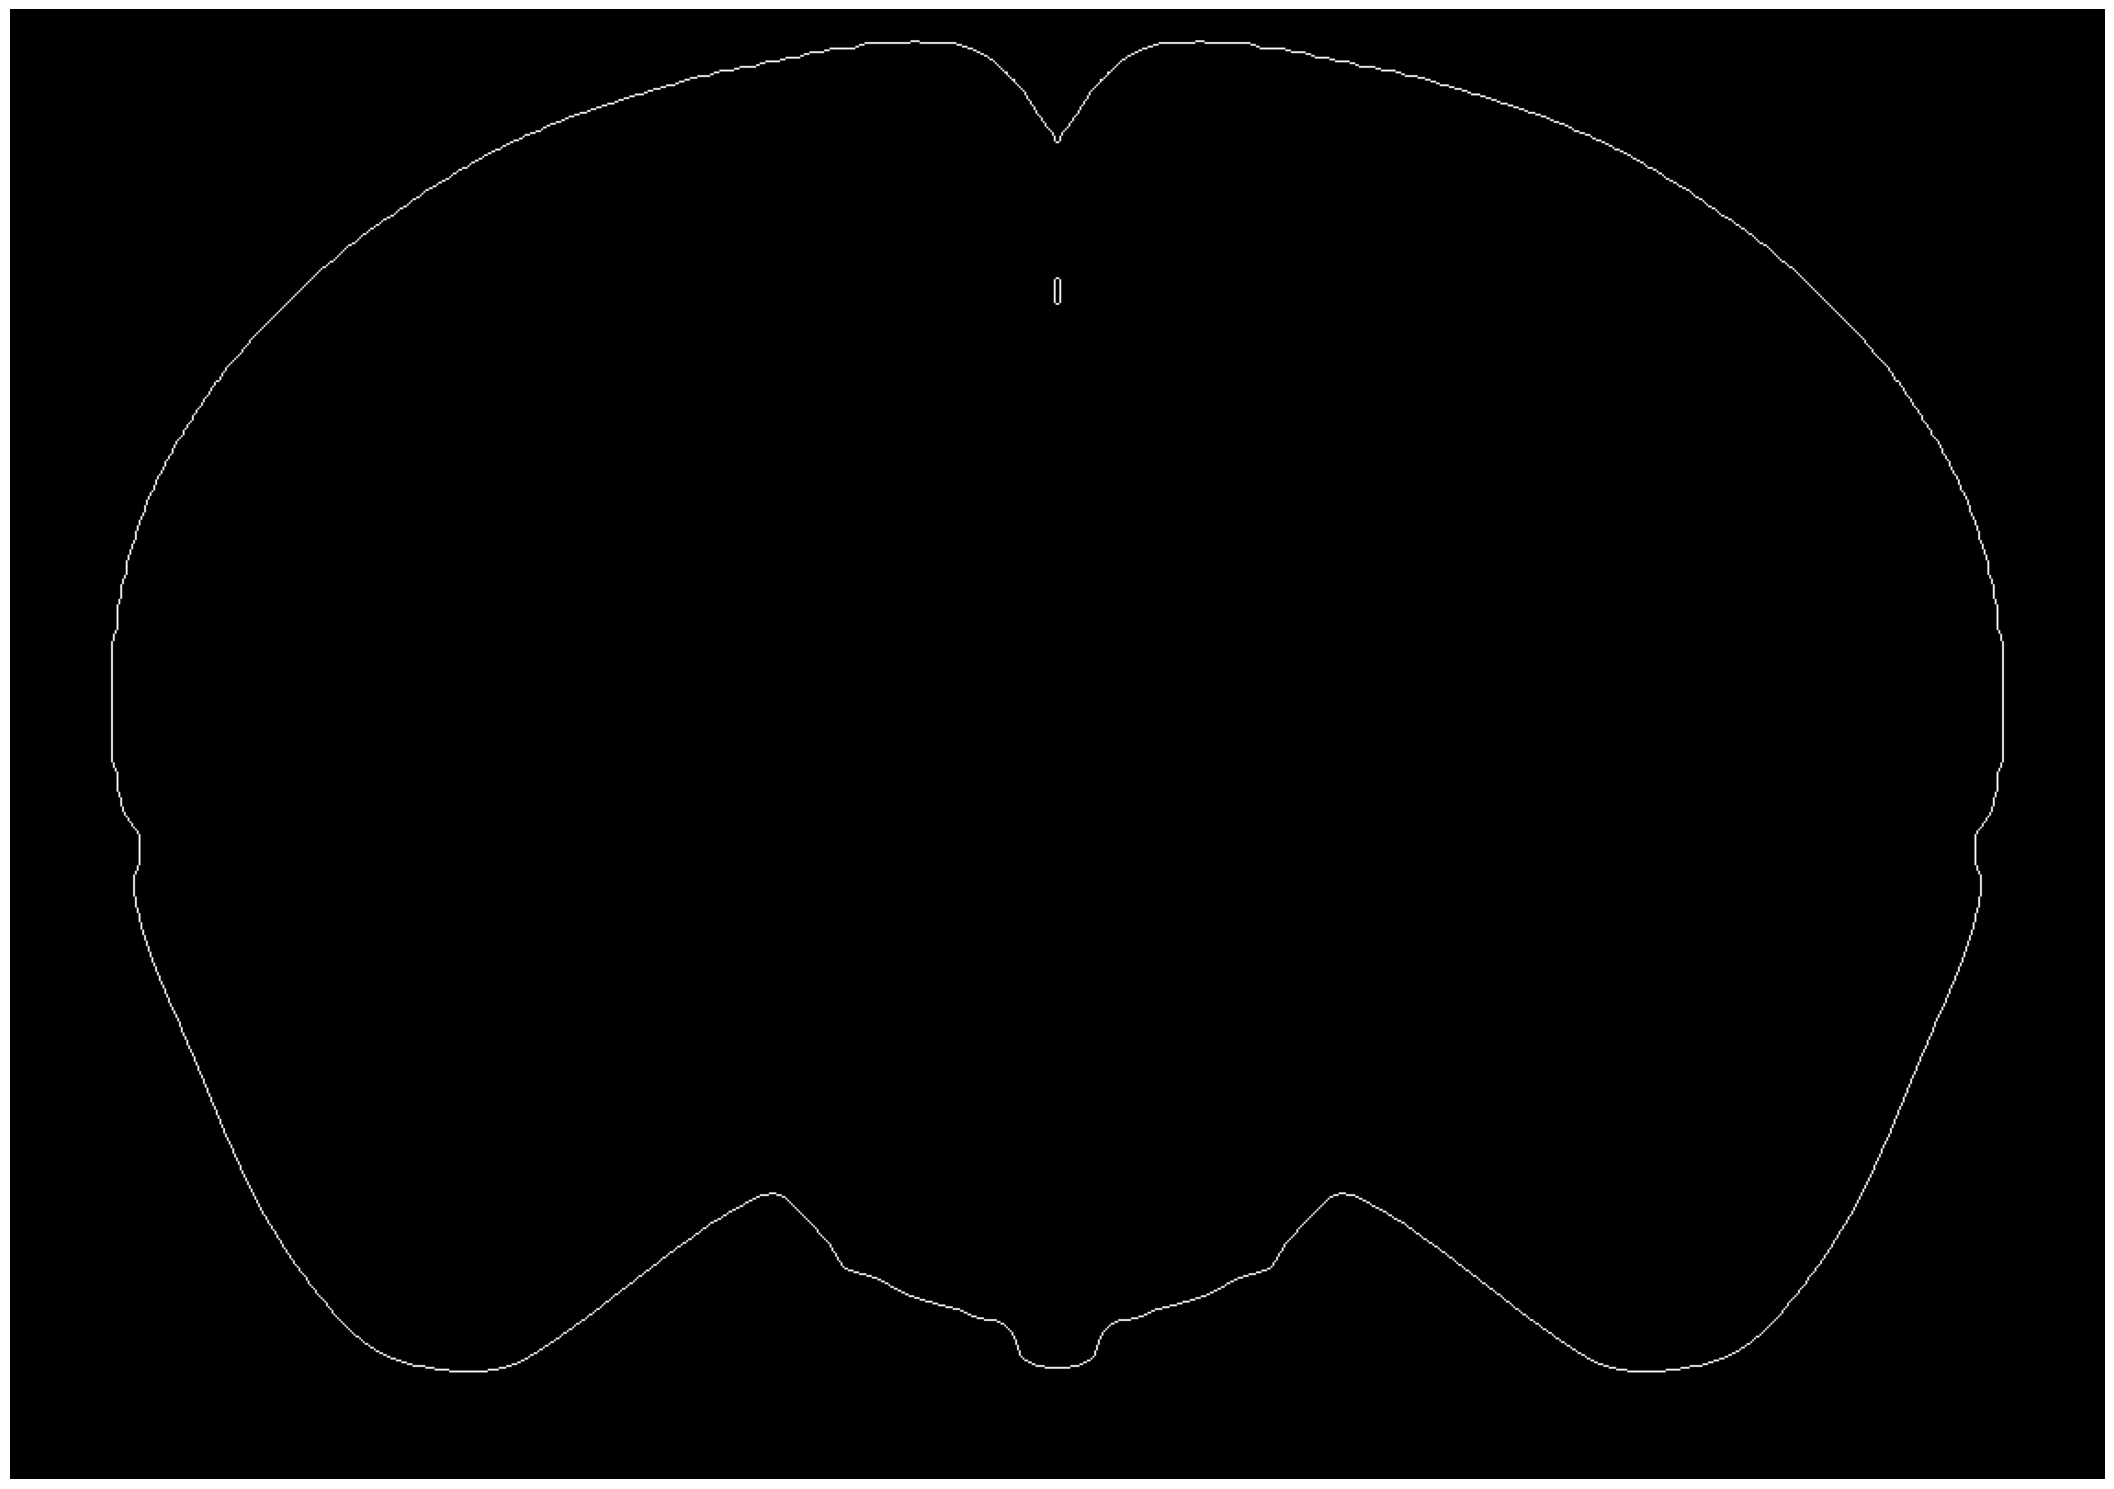

In [88]:
roi = (slice(None), slice(None))
# roi = (slice(130, 420), slice(70, 385))
# roi = (slice(200, 300), slice(100, 200))

overlay = np.zeros(
    ((np.array(shape) * 2.5).astype(np.uint16))[np.where(np.array(index) == -1)[0]].T,
    dtype=np.uint8,
)
draw_contours(overlay, contours)
overlay = overlay[roi]

imshow(overlay, figsize=(30, 15))